# Load Zarr Image with labels from a public S3 repository, analyze using ilastik and compare results.
The notebook shows how to load an IDR image converted into a Zarr file with labels.

The image is referenced in the paper "NesSys: a novel method for accurate nuclear segmentation in 3D" published August 2019 in PLOS Biology: https://doi.org/10.1371/journal.pbio.3000388 and can be viewed online in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/?show=image-6001247).

This original image was converted into the Zarr format. The analysis results produced by the paper authors were converted into labels and linked to the Zarr file which was placed into a public S3 repository.

In this notebook, the converted Zarr file is then loaded together with the labels from the S3 storage and analyzed using [ilastik](https://ilastik.github.io/). The ilastik analysis produces a probability map based on pixel classification. These probability maps are then viewed side-by-side with the original segmentations produced by the authors of the papers obtained via the loaded labels.

If you run this notebook with different images or ilastik projects, the dimension might need to be adjusted depending on the ilastik project.

### Insert required packages

In [1]:
import os
import numpy
import zarr
import dask.array as da
from dask.diagnostics import ProgressBar

from ilastik import app
from ilastik.applets.dataSelection.opDataSelection import PreloadedArrayDatasetInfo
import vigra

### Enter the image ID

In [2]:
image_id = 6001247

### Helper method to load an Image as 5D-numpy array from S3

In [3]:
def load_from_s3(id, resolution='0'):
    endpoint_url = 'https://uk1s3.embassy.ebi.ac.uk/'
    root = 'idr/zarr/v0.1/%s.zarr/%s/' % (id, resolution)
    # data.shape is (t, c, z, y, x) by convention
    with ProgressBar():
        return numpy.asarray(da.from_zarr(endpoint_url + root))

### Helper method to load the labels linked to the Image from S3 

In [4]:
def load_labels_from_s3(id, resolution='0'):
    endpoint_url = 'https://uk1s3.embassy.ebi.ac.uk/'
    root = 'idr/zarr/v0.1/%s.zarr/labels/%s/' % (id, resolution)
    return da.from_zarr(endpoint_url + root)

### Load the image data

In [5]:
%time input_data = load_from_s3(image_id)

[########################################] | 100% Completed | 5.06 sms
CPU times: user 2 s, sys: 507 ms, total: 2.51 s
Wall time: 5.69 s


### Load the labels

In [6]:
labels = load_labels_from_s3(image_id)

### Store the original image channels for later comparison with probability map generated by ilastik.

In [7]:
first_channel = input_data[0, 0, :, : ,:]
second_channel = input_data[0, 1, :, : ,:]

### Load each image as a 5D-numpy array.

In [8]:
# Re-order the array tczyx -> tzyxc
print(input_data.shape)
input_data = input_data.swapaxes(1, 2).swapaxes(2, 3).swapaxes(3, 4)
print(input_data.shape)

(1, 2, 257, 210, 253)
(1, 257, 210, 253, 2)


### Analyze data
We are now running an ilastik pixel classication pipeline on the data.
Running the analysis could take a few minutes.

In [9]:
# Load the model linked to the image
model_file = "./pipelines/ilastik14-Nov-2024.ilp"


# Prepare ilastik
os.environ["LAZYFLOW_THREADS"] = "2"
os.environ["LAZYFLOW_TOTAL_RAM_MB"] = "2000"
args = app.parse_args([])
args.headless = True
args.project = model_file
shell = app.main(args)

print('running ilastik using %s' % model_file)
role_data_dict = [ {"Raw Data": PreloadedArrayDatasetInfo(preloaded_array=input_data, axistags=vigra.defaultAxistags("tzyxc"))}]
predictions = shell.workflow.batchProcessingApplet.run_export(role_data_dict, export_to_array=True)
for data in predictions:
    # Re-organise array from tzyxc to tczyx order
    data = data.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1)
    data_viewer = data[0, 0, :, :, :]
print("done")

INFO ilastik.app: Using tiktorch executable: ['/Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/bin/python', '-m', 'tiktorch.server']
INFO ilastik.app: config file location: <none>
INFO ilastik.app: Starting ilastik from /Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/lib/python3.9
Starting ilastik from /Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/lib/python3.9
INFO ilastik.app: Resetting lazyflow thread pool with 2 threads.
INFO ilastik.app: Configuring lazyflow RAM limit to 2.0GiB
INFO lazyflow.utility.memory: Available memory set to 2.0GiB


WARNING 2024-10-30 20:54:11,490 opConservationTracking 89273 8602723840 Could not find any ILP solver
WARNING 2024-10-30 20:54:11,501 opStructuredTracking 89273 8602723840 Could not find any ILP solver
WARNING 2024-10-30 20:54:11,502 structuredTrackingWorkflow 89273 8602723840 Could not find any learning solver. Tracking will use flow-based solver (DPCT). Learning for tracking will be disabled!


INFO ilastik.shell.projectManager: Opening Project: ./pipelines/ilastik14-Nov-2024.ilp
running ilastik using ./pipelines/ilastik14-Nov-2024.ilp
DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty
DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty
DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty
DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty
INFO ilastik.applets.batchProcessing.batchProcessingApplet: Exporting to in-memory array.
INFO lazyflow.utility.bigRequestStreamer: Estimated RAM usage per pixel is 120.0B * safety factor (2.0)
INFO lazyflow.utility.bigRequestStreamer: determining blockshape assuming available_ram is 1.5GiB, split between 2 threads
INFO lazyflow.utility.bigRequestStreamer: Chose blockshape: (1, 148, 149, 148, 2)
INFO lazyflow.utility.bigRequestStreamer:

###  Compare raw data with the ilastik result.
View the first channel of the original image (left) and the probability map created by pixel classification module of ilastik (right) side-by-side.

<Figure size 20000x20000 with 0 Axes>

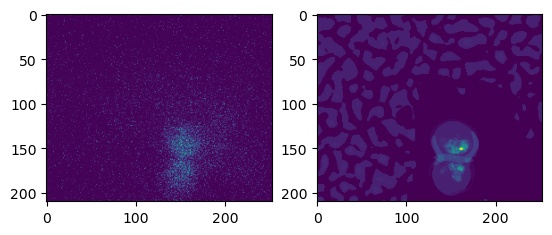

In [10]:

import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(200, 200))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(first_channel[0, :, :])
axarr[1].imshow(data_viewer[0, :, :])

### Compare the original analysis result with the ilastik result.

On the left, the labels loaded from S3 representing the original analysis by the authors of the paper. On the rigth, the probability maps from the pixel classification module of ilastik.

The first 2 z-planes do not have labels.

<Figure size 20000x20000 with 0 Axes>

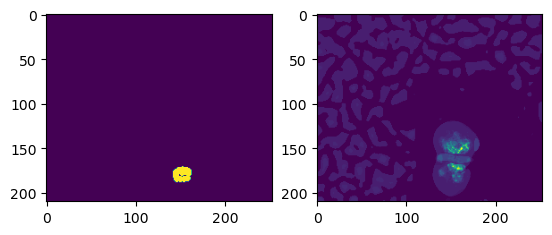

In [29]:

fig = plt.figure(figsize=(200, 200))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(labels[0, 0, 2, :, :])
axarr[1].imshow(data[0, 0, 2, :, :])


### License (BSD 2-Clause)
Copyright (C) 2019-2024 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.